<font size="3">
    
## Анализ зависимости результата от функции ошибок/выбросов (в двумерном случае)
    
В этой работе был проведен анализ зависимости линейного регрессора от используемых фунций ошибок MSE и MAE, а также от выбросов. 

Была реализована функция для генерации точек с выбросами и простого управления сдвигом выбросов.

    За выявление выбросов отвечает RANSACRegressor
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html

Для представления линейной регрессии с функцией ошибки MSE был использован метод LinearRegression из sklearn.linear_model с параметрами по умолчанию.

Для представления линейной регрессии с функцией ошибки MAE был использован метод SGDRegressor из sklearn.linear_model c функцией ошибки epsilon_insensitive и eps = 0 ($\epsilon$ = 0), что как раз эквивалентно MAE. 

Объяснение:

Выкладка из $mathworks.com$:
Линейная $\epsilon$-insensitive функция потерь игнорирует ошибки, которые находятся в пределах расстояния $\epsilon$ от наблюдаемого значения, рассматривая их как равные нулю. Потери измеряются на основе расстояния между наблюдаемым значением $y$ и границей $\epsilon$. Формально это описывается
\begin{equation*}
L_{\epsilon} = 
 \begin{cases}
   0 &\text{если $|y - f(x)| \leqslant \epsilon$}\\
   |y - f(x)| - \epsilon &\text{иначе}
 \end{cases}
\end{equation*}
https://scikit-learn.org/stable/modules/sgd.html#sgd-mathematical-formulation
https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html

За оценку устойчивости высчитывается площадь между графиками в области медианы $(x_{median} - \delta, x_{median} + \delta)$  соответсвенно - чем меньше, тем устойчивее


In [214]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy import trapz

За выявление выбросов отвечает RANSACRegressor

In [215]:
DELTA = 1
def argsort(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)
def GetPointsInInterval(x_exemp,y_exemp,delta):
    return np.array([[y_exemp[i], x_exemp[i]] for i in range(len(x_exemp)) if 
                     -delta <= x_exemp[i] - np.median(x_exemp) <= delta]).T

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RANSACRegressor
SMALL_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)


# data: 1000 obs, 100 of them are outliers
# =====================================================

# the last 100 are outliers
def getcullc(a,d,n):
    robust_estimator = RANSACRegressor(random_state=0)
    robust_estimator.fit(np.vstack([a,b]).T, d)
    d_pred = robust_estimator.predict(np.vstack([a,b]).T)

    mse = (d - d_pred.ravel()) ** 2

    index = argsort(mse)
    
    regr = linear_model.LinearRegression()
    regr.fit(np.array([[i] for i in a[index[:-n]]]),  d[index[:-n]])
    a1 = regr.predict(np.array([[i] for i in a[index[:-n]]]))
    regr.fit(np.array([[i] for i in a[index]]),  d[index])
    a2 = regr.predict(np.array([[i] for i in a[index]]))
    
    regs = make_pipeline(StandardScaler(), SGDRegressor(loss = 'epsilon_insensitive', epsilon = 0, max_iter=1000))
    regs.fit(np.array([[i] for i in a[index[:-n]]]),  d[index[:-n]])
    b1 = regs.predict(np.array([[i] for i in a[index[:-n]]]))
    regs.fit(np.array([[i] for i in a[index]]),  d[index])
    b2 = regs.predict(np.array([[i] for i in a[index]]))
    
    fig, axes = plt.subplots(ncols=1, sharey=True,figsize=(25,25))
    axes.scatter(a[index[:-n]], d[index[:-n]], c='b', label='inliers', alpha = 0.4)
    axes.scatter(a[index[-n:]], d[index[-n:]], c='r', label='outliers',alpha = 0.4)
    
    axes.plot(a[index[:-n]], a1, '-.c',label='MSE',linewidth=4)
    axes.plot(a[index], a2, '-.r',label='MSE with outliers',linewidth=4)
    axes.plot(a[index[:-n]], b1, '--k',label='MAE',linewidth=4)
    axes.plot(a[index], b2, '--g',label='MAE with outliers',linewidth=4)

    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.legend(loc='best')
    y, x = GetPointsInInterval(a[index[:-n]], np.abs(a1 - a2[:-n]), DELTA)
    print("For MSE: ", trapz(y,x))
    y, x = GetPointsInInterval(a[index[:-n]], np.abs(b1 - b2[:-n]), DELTA)
    print("For MAE: ", trapz(y,x))

Несколько последних сгенерированных точек сдвигается на (OutByX, OutByY)

In [216]:
# numofoutliers = 50
def generalfunc(numofoutliers, OutByX, OutByY):
    np.random.seed(42)
    a = np.random.randn(1000)
    b = np.random.randn(1000)
    d = 2 * a - b + np.random.randn(1000)
    a[-numofoutliers:] = a[-numofoutliers:] + OutByX * np.abs(np.random.randn(50))
    d[-numofoutliers:] = d[-numofoutliers:] + OutByY * np.abs(np.random.randn(numofoutliers))
    getcullc(a,d,numofoutliers)

Здесь и дальше общее количество точек = 1000, выбросов около 50 - не точное количество выбросов из-за того, что его количество высчитывается в дальнейшем по усмотрению RANSACRegressor

For MSE:  0.02364159866201597
For MAE:  0.011642123442530627


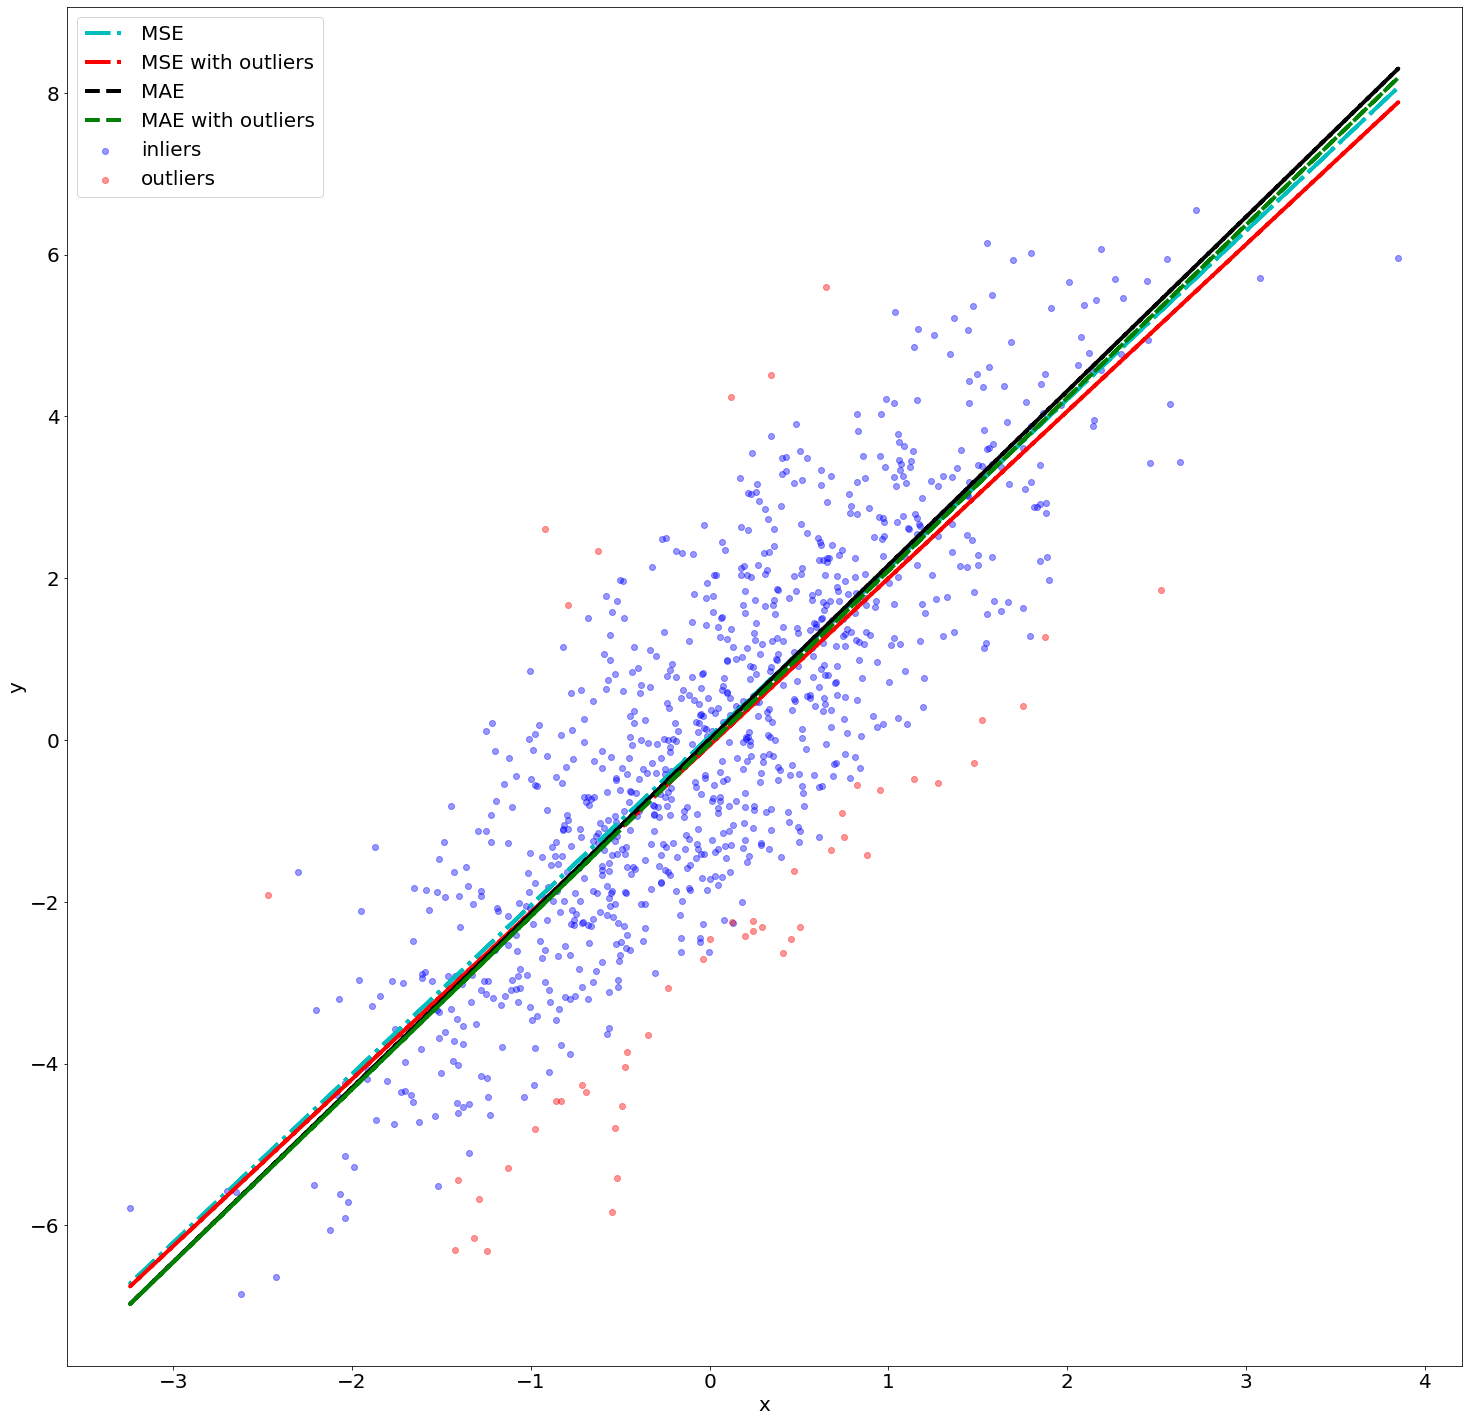

In [217]:
generalfunc(50,0,0)

Из картинки выше видно, что выбросы такого вида визуально не сильно портят наш результат для обеих функций

For MSE:  0.06057597216772814
For MAE:  0.0019482658765849308


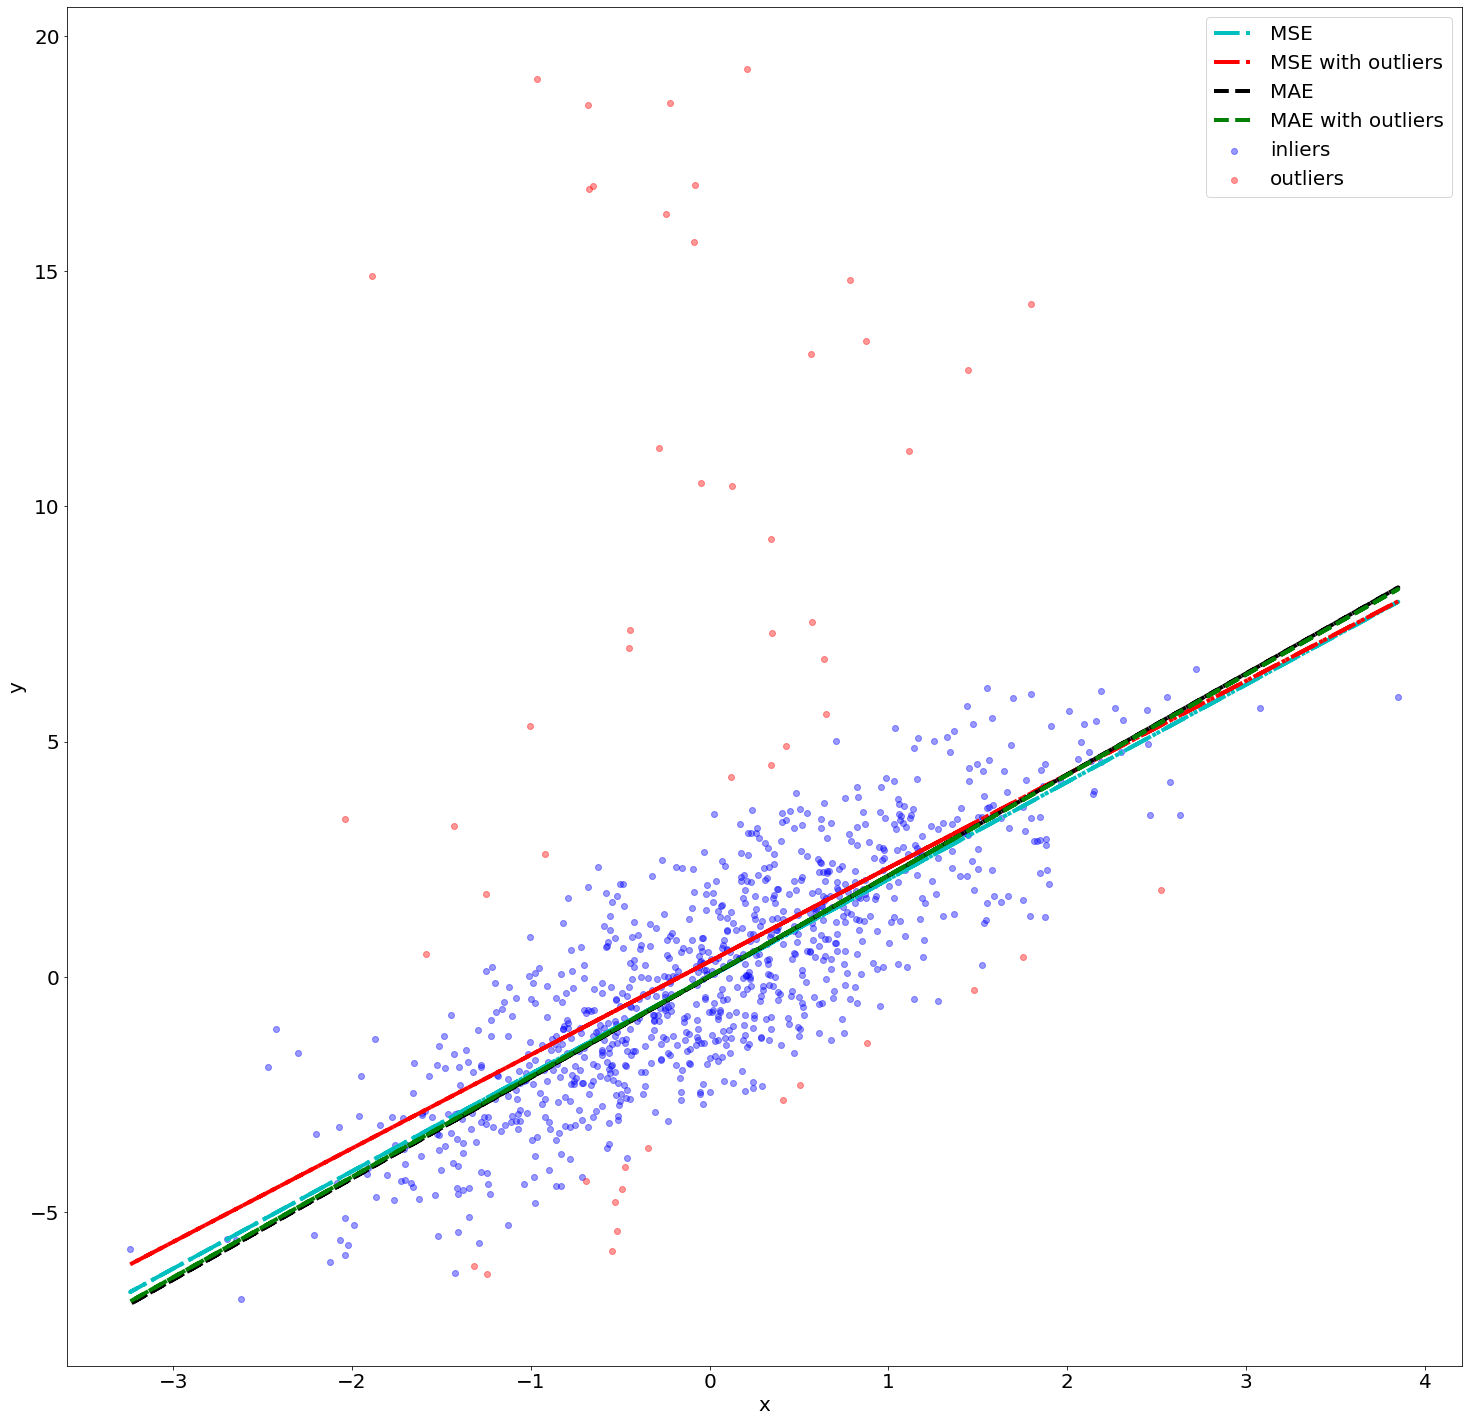

In [218]:
generalfunc(50,0,10)

Выбросы, сдвинутые чуть выше по оси y сильнее меняют результат по функции MSE, MAE показывает результат получше

For MSE:  1.7130961600693058
For MAE:  0.02373864668506165


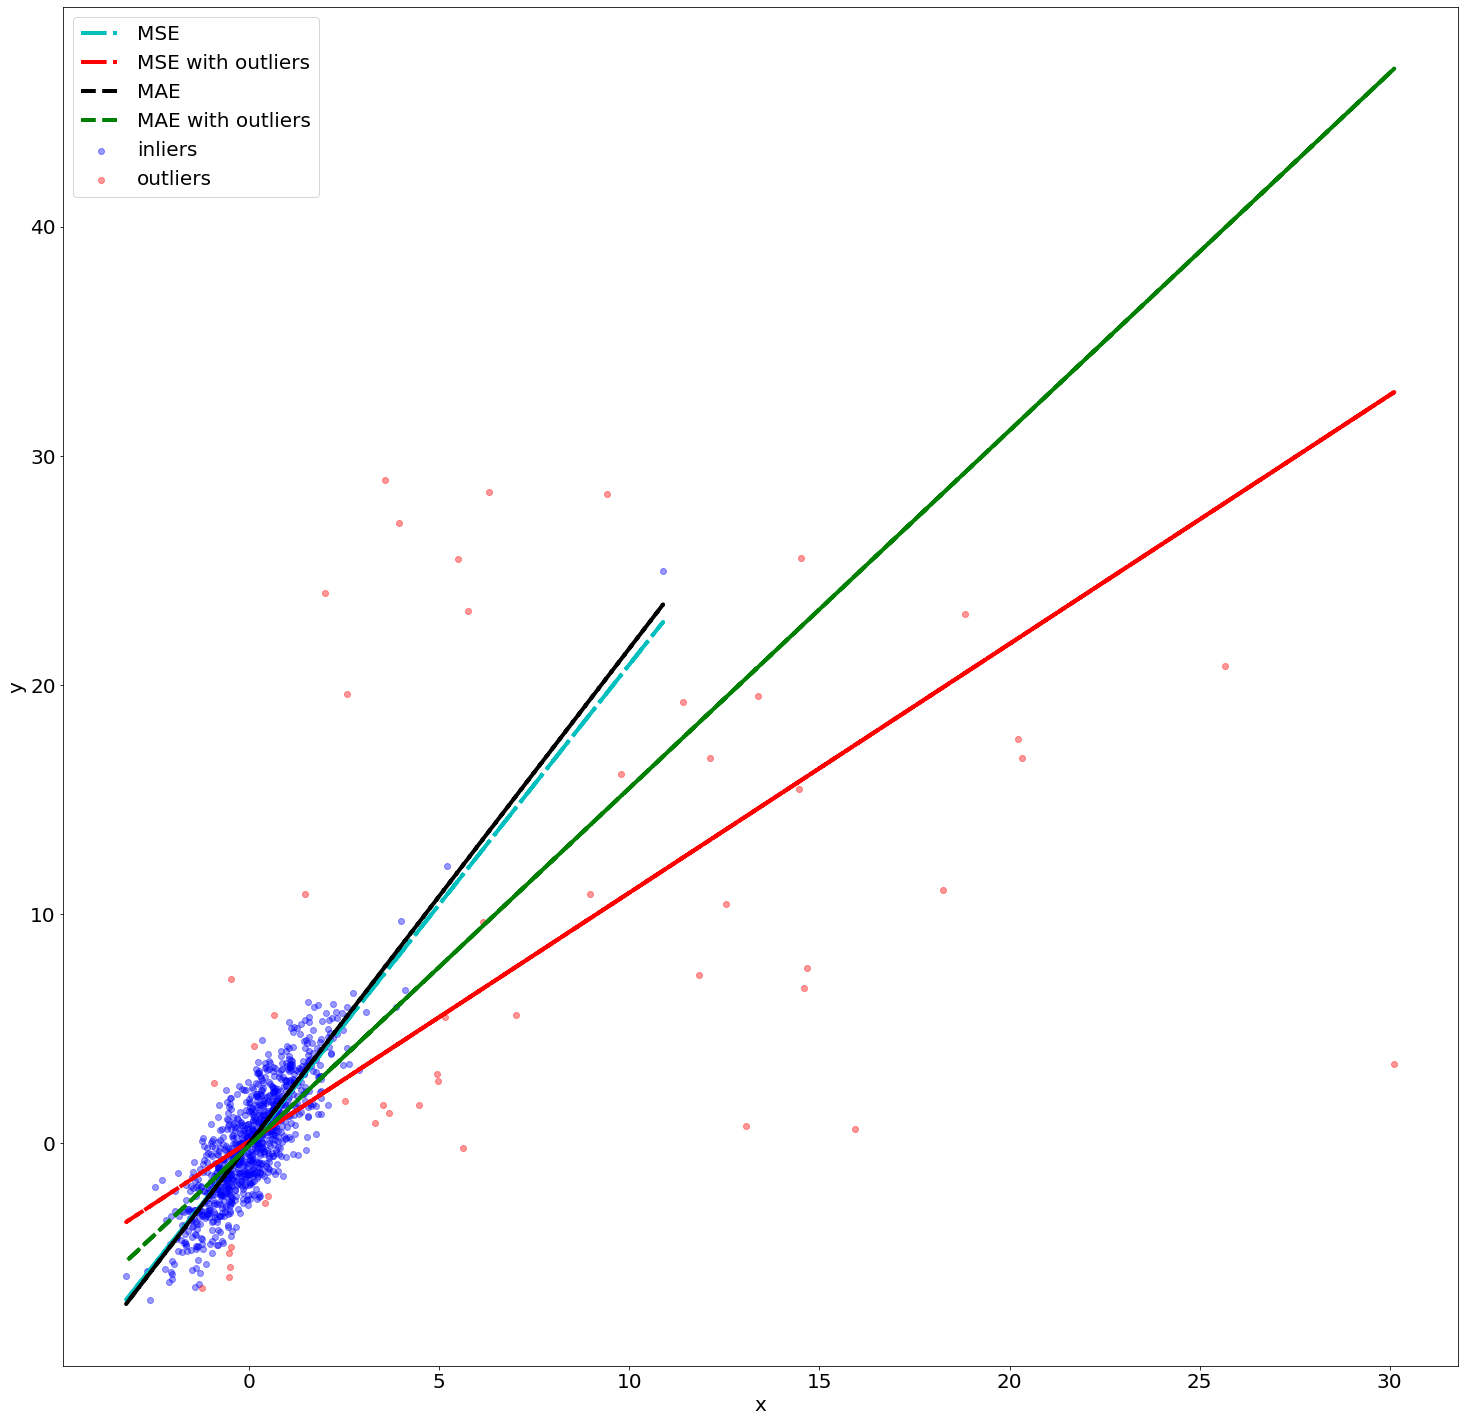

In [219]:
generalfunc(50,10,15)

Здесь выше видно явно, что сильные сдвиги выбросов влияют очень сильно на результат по функции MSE, а по MAE результаты чуть лучше

For MSE:  0.408518526854864
For MAE:  0.00973681147227759


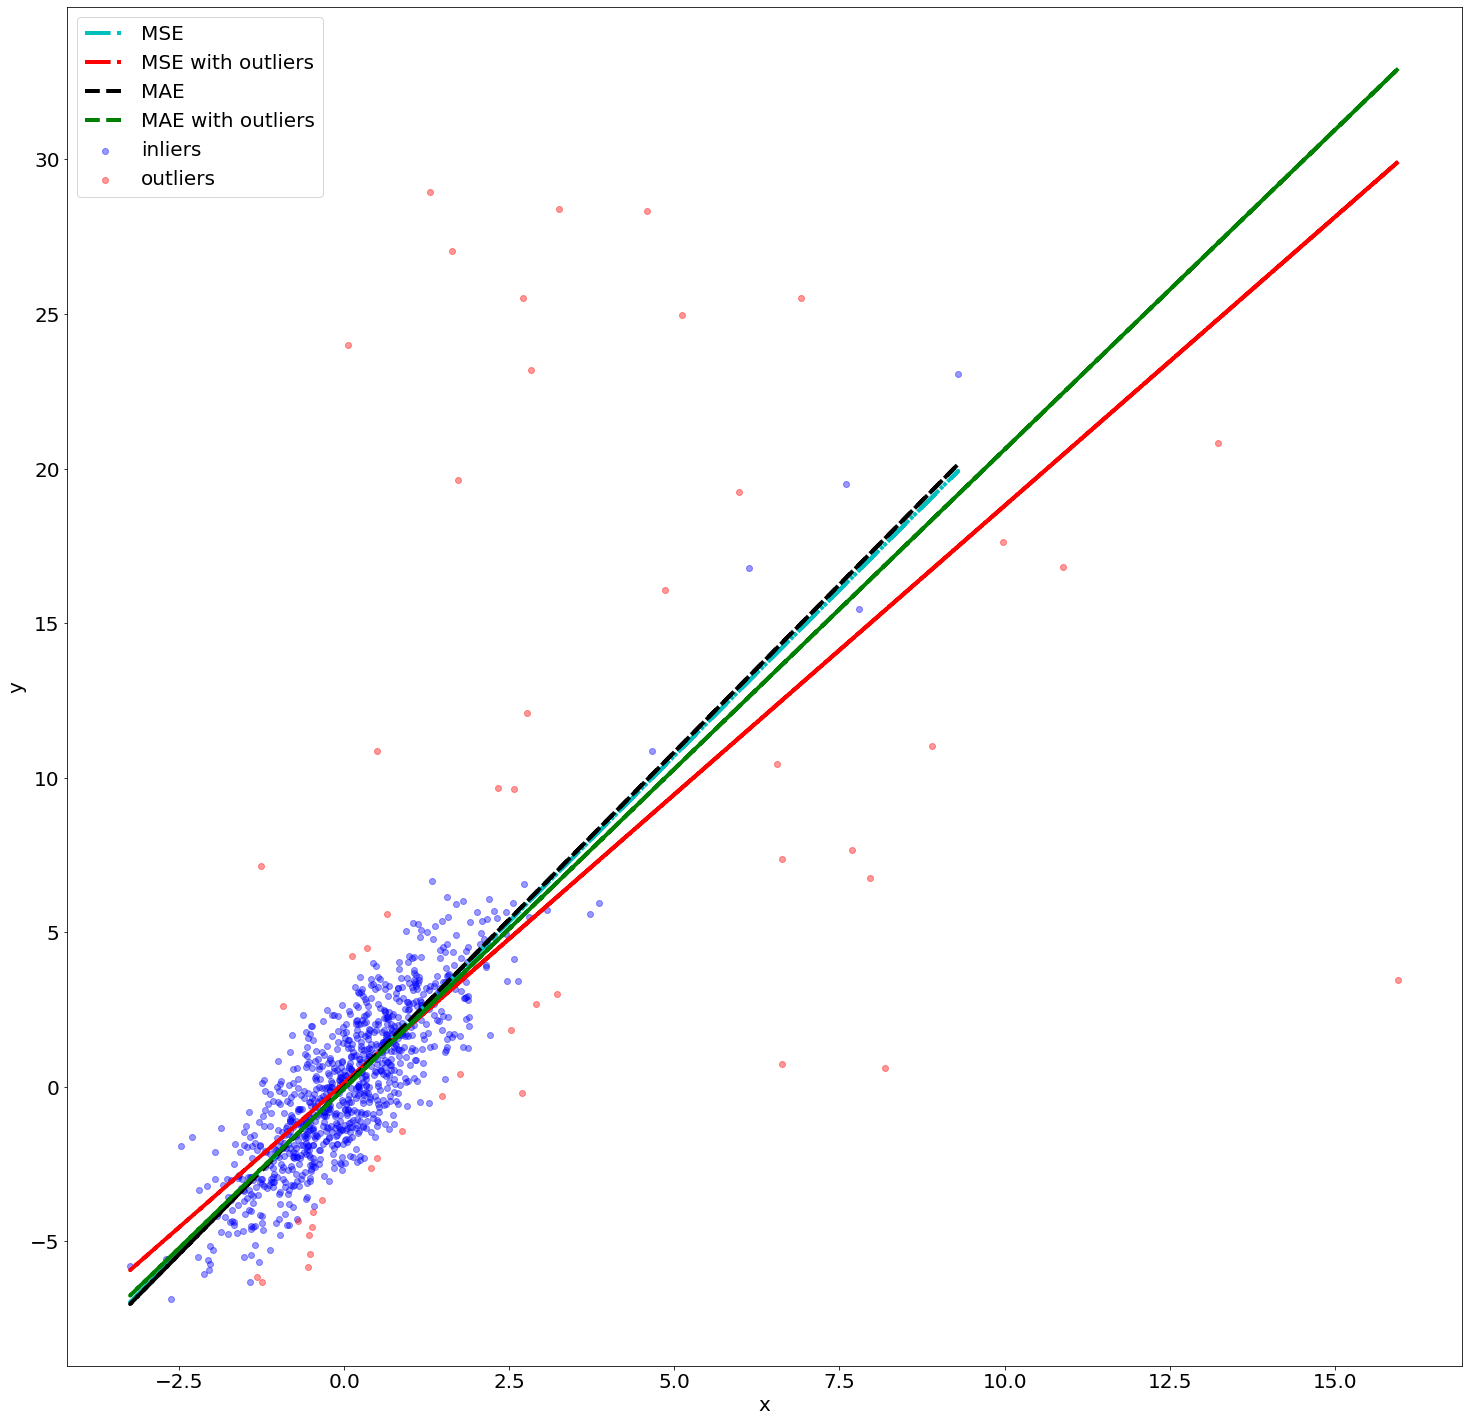

In [220]:
generalfunc(50,5,15)

Здесь выбросы сильные, но влияние на результат не самое большое. Даже при всем при этом результат по MAE всё ещё лучше терпит выбросы.

Вывод: по этому небольшому примеру можно сказать, что линейная регрессия с функцией ошибок MAE лучше терпит выбросы по отношению к той же линейной регрессии, но с функцией ошибок MSE